In [11]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  
%config InlineBackend.figure_format ='retina'

In [12]:
def read_data(result_dir = "sgd-grda_c0.001_mu0.501_eval_curve", data_name = 'te_nll'):
    data = np.load(result_dir + ".npz")
    return data['ts'], data[data_name]


In [13]:
import argparse
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import os
import seaborn as sns

SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 14

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=SMALL_SIZE)  # fontsize of the figure title

In [14]:
folders = [file for file in os.listdir() if not os.path.isfile(file)]
folders_all = []
for folder in folders:
    if folder[0] != '.' and folder == 'result_cifar100_wrn':
        folders_all.append(folder)

In [15]:
matplotlib.rc('text', usetex=False)

matplotlib.rc('xtick.major', pad=12)
matplotlib.rc('ytick.major', pad=12)
matplotlib.rc('grid', linewidth=0)

sns.set_style('whitegrid')


class LogNormalize(colors.Normalize):

    def __init__(self, vmin=None, vmax=None, clip=None, log_alpha=None):
        self.log_alpha = log_alpha
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        log_v = np.ma.log(value - self.vmin)
        log_v = np.ma.maximum(log_v, self.log_alpha)
        return 0.9 * (log_v - self.log_alpha) / (np.log(self.vmax - self.vmin) - self.log_alpha)


def plane(axs_sub, grid, values, vmax=None, log_alpha=-5, N=7, cmap='jet_r', format_colorbar='%.1e'):
    cmap = plt.get_cmap(cmap)
    if vmax is None:
        clipped = values.copy()
    else:
        clipped = np.minimum(values, vmax)
    log_gamma = (np.log(clipped.max() - clipped.min()) - log_alpha) / N
    levels = clipped.min() + np.exp(log_alpha + log_gamma * np.arange(N + 1))
    levels[0] = clipped.min()
    levels[-1] = clipped.max()
    levels = np.concatenate((levels, [1e10]))
    norm = LogNormalize(clipped.min() - 1e-8, clipped.max() + 1e-8, log_alpha=log_alpha)
    contourf = axs_sub.contourf(grid[:, :, 0], grid[:, :, 1], values, cmap=cmap, norm=norm,
                            levels=levels,
                            zorder=0,
                            alpha=0.8)
    colorbar = fig.colorbar(contourf, ax=axs_sub, format=format_colorbar, location='left')
    

    labels = list(colorbar.ax.get_yticklabels())
    colorbar.ax.set_yticklabels(labels)
    contour = None
    return contour, contourf, colorbar


In [16]:


import matplotlib.ticker as mticker
f = mticker.ScalarFormatter(useOffset=False, useMathText=True)
g = lambda x,pos : "${}$".format(f._formatSciNotation('%1.1e' % x))

def plot_plane_each_trloss(axs_sub, folder):
    file_read = np.load(folder + "/plane.npz")
    contour, contourf, colorbar = plane(
        axs_sub,
        file_read['grid'],
        file_read['tr_loss'],
        vmax=5.0,
        log_alpha=-5.0,
        N=20,
        cmap='Spectral',
        format_colorbar=mticker.FuncFormatter(g)
    )

    bend_coordinates = file_read['bend_coordinates']
    curve_coordinates = file_read['curve_coordinates']

    axs_sub.scatter(bend_coordinates[[0, 2], 0], bend_coordinates[[0, 2], 1], marker='o', c='w', s=120, zorder=2)
    axs_sub.plot(curve_coordinates[:, 0], curve_coordinates[:, 1], linewidth=4, c='w', label='$w(t)$', zorder=4)

    axs_sub.margins(0.0)
    axs_sub.tick_params(axis='both', labelsize=14)



def plot_plane_each_teerror(axs_sub, folder):
    file_read = np.load(folder + "/plane.npz")
    contour, contourf, colorbar = plane(
        axs_sub,
        file_read['grid'],
        file_read['te_err'],
        vmax=40,
        log_alpha=-1.0,
        N=20,
        cmap='Spectral',
        format_colorbar=mticker.FuncFormatter(g)
    )

    bend_coordinates = file_read['bend_coordinates']
    curve_coordinates = file_read['curve_coordinates']

    axs_sub.scatter(bend_coordinates[[0, 2], 0], bend_coordinates[[0, 2], 1], marker='o', c='w', s=120, zorder=2)
    axs_sub.plot(curve_coordinates[:, 0], curve_coordinates[:, 1], linewidth=4, c='w', label='$w(t)$', zorder=4)

    axs_sub.margins(0.0)
    axs_sub.tick_params(axis='both', labelsize=14)

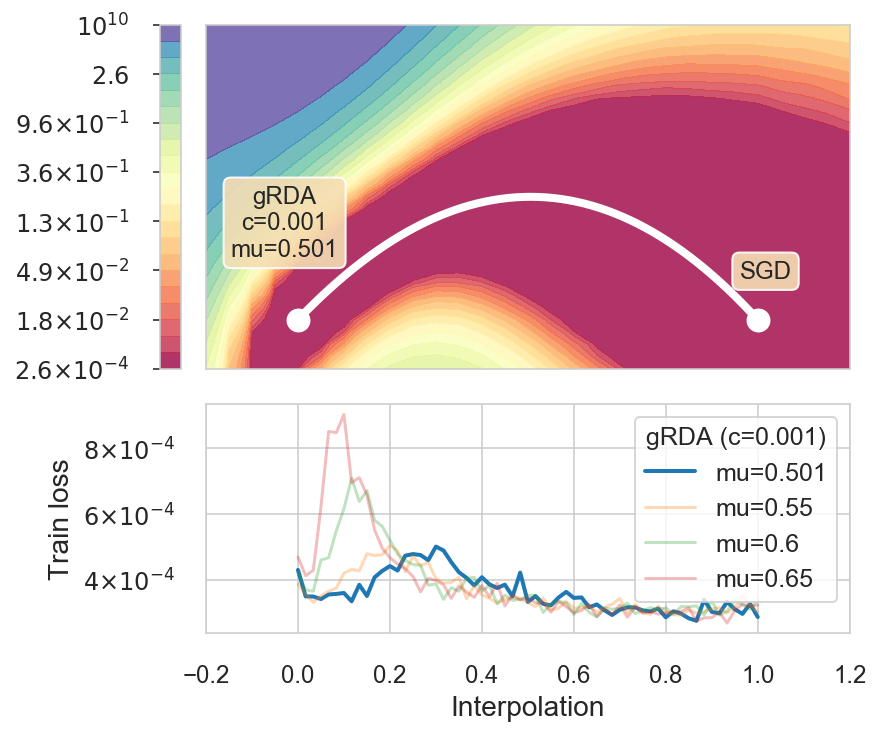

In [17]:

import matplotlib.ticker as mtick
plt.rcParams.update({'font.size': 12.5})

fig = plt.figure(figsize=(6,5), constrained_layout=True)
widths = [1]
heights = [3, 2]
spec5 = fig.add_gridspec(ncols=1, nrows=2, width_ratios=widths,
                          height_ratios=heights)



if len(folders_all) == 1:
    # axs_sub = axs[0][0]
    axs_sub = fig.add_subplot(spec5[0, 0])
    plt.setp( axs_sub.get_xticklabels(), visible=False)
    plt.setp( axs_sub.get_yticklabels(), visible=False)
    plot_plane_each_trloss(axs_sub, folders_all[0]) # mu0.6

textstr = """gRDA\nc=0.001\nmu=0.501"""
props = dict(boxstyle='round', facecolor='wheat', alpha=0.9)
axs_sub.text(-2, 4, textstr, fontsize=12, horizontalalignment='center', verticalalignment='center', bbox=props)
textstr = """SGD"""
props = dict(boxstyle='round', facecolor='wheat', alpha=0.9)
axs_sub.text(70, 2, textstr, fontsize=12, horizontalalignment='center', verticalalignment='center', bbox=props)

matplotlib.rc('grid', linewidth=0.8)

# ax = axs[1][0]
ax = fig.add_subplot(spec5[1, 0])
data_name = 'tr_loss'
alpha_value = 0.3
a, = ax.plot(*read_data(result_dir = "sgd-grda_c0.001_mu0.501_eval_curve", data_name = data_name), alpha = 1, lw=2)
b, = ax.plot(*read_data(result_dir = "sgd-grda_c0.001_mu0.55_eval_curve", data_name = data_name), alpha = alpha_value)
c, = ax.plot(*read_data(result_dir = "sgd-grda_c0.001_mu0.6_eval_curve", data_name = data_name), alpha = alpha_value)
d, = ax.plot(*read_data(result_dir = "sgd-grda_c0.001_mu0.65_eval_curve", data_name = data_name), alpha = alpha_value)
ax.yaxis.set_major_formatter(mticker.FuncFormatter(g))
ax.legend([a,b,c,d],["mu=0.501", "mu=0.55", "mu=0.6", "mu=0.65"], loc='upper right', title="gRDA (c=0.001)", fontsize=12.5)
# plt.title('Evalution of Bezier curve connecting gRDA and SGD\n (t=0 is gRDA, t=1 is SGD | Data: CIFAR100, Architecture: WideResNet28x10)')
ax.set_ylabel('Train loss', fontsize=14)
ax.set_xlabel('Interpolation', fontsize=14)
ax.set_xlim(-0.2, 1.2)
ax.grid(True)




plt.savefig('cifar100_mu0501_conn_train.pdf')

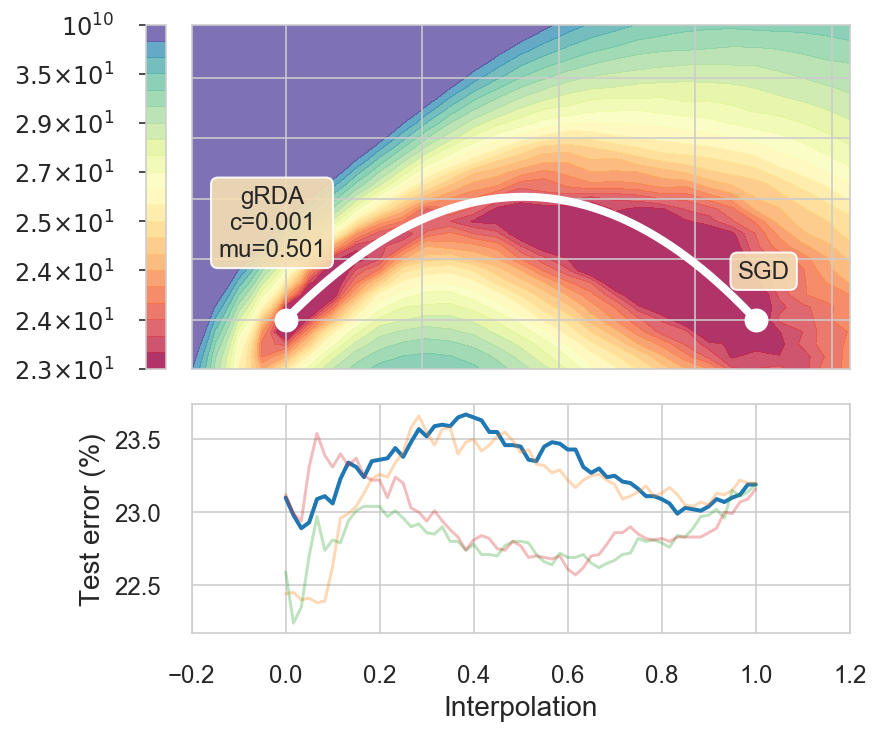

In [18]:

import matplotlib.ticker as mtick
plt.rcParams.update({'font.size': 12.5})

fig = plt.figure(figsize=(6,5), constrained_layout=True)
widths = [1]
heights = [3, 2]
spec5 = fig.add_gridspec(ncols=1, nrows=2, width_ratios=widths,
                          height_ratios=heights)



if len(folders_all) == 1:
    axs_sub = fig.add_subplot(spec5[0, 0])
    plt.setp( axs_sub.get_xticklabels(), visible=False)
    plt.setp( axs_sub.get_yticklabels(), visible=False)
    plot_plane_each_teerror(axs_sub, folders_all[0])
textstr = """gRDA\nc=0.001\nmu=0.501"""
props = dict(boxstyle='round', facecolor='wheat', alpha=0.9)
axs_sub.text(-2, 4, textstr, fontsize=12, horizontalalignment='center', verticalalignment='center', bbox=props)
textstr = """SGD"""
props = dict(boxstyle='round', facecolor='wheat', alpha=0.9)
axs_sub.text(70, 2, textstr, fontsize=12, horizontalalignment='center', verticalalignment='center', bbox=props)

matplotlib.rc('grid', linewidth=0.8)

# ax = axs[1][0]
ax = fig.add_subplot(spec5[1, 0])


data_name = 'te_err'
a, = ax.plot(*read_data(result_dir = "sgd-grda_c0.001_mu0.501_eval_curve", data_name = data_name), alpha = 1, lw=2)
b, = ax.plot(*read_data(result_dir = "sgd-grda_c0.001_mu0.55_eval_curve", data_name = data_name), alpha = alpha_value)
c, = ax.plot(*read_data(result_dir = "sgd-grda_c0.001_mu0.6_eval_curve", data_name = data_name), alpha = alpha_value)
d, = ax.plot(*read_data(result_dir = "sgd-grda_c0.001_mu0.65_eval_curve", data_name = data_name), alpha = alpha_value)

ax.set_ylabel('Test error (%)', fontsize=14)
ax.set_xlabel('Interpolation', fontsize=14)
ax.set_xlim(-0.2, 1.2)
ax.grid(True)


plt.savefig('cifar100_mu0501_conn_test.pdf')